<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/transform/census">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.sandbox.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/transform/census.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/transform/census.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a target="_blank" href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/transform/census.ipynb">
<img width=32px src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a></td>
</table></div>

##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Preprocessing data with TensorFlow Transform
***The Feature Engineering Component of TensorFlow Extended (TFX)***

This example colab notebook provides a somewhat more advanced example of how <a target='_blank' href='https://www.tensorflow.org/tfx/transform/get_started'>TensorFlow Transform</a> (`tf.Transform`) can be used to preprocess data using exactly the same code for both training a model and serving inferences in production.

TensorFlow Transform is a library for preprocessing input data for TensorFlow, including creating features that require a full pass over the training dataset.  For example, using TensorFlow Transform you could:

* Normalize an input value by using the mean and standard deviation
* Convert strings to integers by generating a vocabulary over all of the input values
* Convert floats to integers by assigning them to buckets, based on the observed data distribution

TensorFlow has built-in support for manipulations on a single example or a batch of examples. `tf.Transform` extends these capabilities to support full passes over the entire training dataset.

The output of `tf.Transform` is exported as a TensorFlow graph which you can use for both training and serving. Using the same graph for both training and serving can prevent skew, since the same transformations are applied in both stages.

Key Point: In order to understand `tf.Transform` and how it works with Apache Beam, you'll need to know a little bit about Apache Beam itself.  The <a target='_blank' href='https://beam.apache.org/documentation/programming-guide/'>Beam Programming Guide</a> is a great place to start.

##What we're doing in this example

In this example we'll be processing a <a target='_blank' href='https://archive.ics.uci.edu/ml/machine-learning-databases/adult'>widely used dataset containing census data</a>, and training a model to do classification.  Along the way we'll be transforming the data using `tf.Transform`.

Key Point: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about <a target='_blank' href='https://developers.google.com/machine-learning/fairness-overview/'>ML fairness</a>.

Note: <a target='_blank' href='https://www.tensorflow.org/tfx/model_analysis'>TensorFlow Model Analysis</a> is a powerful tool for understanding how well your model predicts for various segments of your data, including understanding how your model may reinforce societal biases and disparities.

### Install TensorFlow Transform


In [2]:
!pip install tensorflow-transform

In [3]:
# This cell is only necessary because packages were installed while python was
# running. It avoids the need to restart the runtime when running in Colab.
import pkg_resources
import importlib

importlib.reload(pkg_resources)

/tmpfs/tmp/ipykernel_186972/639106435.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


<module 'pkg_resources' from '/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/pkg_resources/__init__.py'>

## Imports and globals

First import the stuff we need.

In [4]:
import math
import os
import pprint

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
print('TF: {}'.format(tf.__version__))

import apache_beam as beam
print('Beam: {}'.format(beam.__version__))

import tensorflow_transform as tft
import tensorflow_transform.beam as tft_beam
from tensorflow_transform.keras_lib import tf_keras
print('Transform: {}'.format(tft.__version__))

from tfx_bsl.public import tfxio
from tfx_bsl.coders.example_coder import RecordBatchToExamplesEncoder

2024-04-30 10:48:55.479069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 10:48:55.479126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 10:48:55.480629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF: 2.15.1


Beam: 2.55.1
Transform: 1.15.0


Next download the data files:

In [5]:
!wget https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.data
!wget https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.test

train_path = './adult.data'
test_path = './adult.test'

--2024-04-30 10:48:57--  https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.data
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 108.177.120.207, 142.250.103.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 3974305 (3.8M) [application/octet-stream]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  --.-KB/s    in 0.02s   

2024-04-30 10:48:58 (165 MB/s) - ‘adult.data’ saved [3974305/3974305]



--2024-04-30 10:48:58--  https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.test
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 108.177.120.207, 142.250.103.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 2003153 (1.9M) [application/octet-stream]
Saving to: ‘adult.test’

adult.test          100%[===================>]   1.91M  --.-KB/s    in 0.01s   

2024-04-30 10:48:58 (145 MB/s) - ‘adult.test’ saved [2003153/2003153]



### Name our columns
We'll create some handy lists for referencing the columns in our dataset.

In [6]:
CATEGORICAL_FEATURE_KEYS = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
]

NUMERIC_FEATURE_KEYS = [
    'age',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'education-num'
]

ORDERED_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label'
]

LABEL_KEY = 'label'

Here's a quick preview of the data:

In [7]:
pandas_train = pd.read_csv(train_path, header=None, names=ORDERED_CSV_COLUMNS)

pandas_train.head(5)

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country   label  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [8]:
one_row = dict(pandas_train.loc[0])

In [9]:
COLUMN_DEFAULTS = [
  '' if isinstance(v, str) else 0.0
  for v in  dict(pandas_train.loc[1]).values()]

The test data has 1 header line that needs to be skipped, and a trailing "." at the end of each line.

In [10]:
pandas_test = pd.read_csv(test_path, header=1, names=ORDERED_CSV_COLUMNS)

pandas_test.head(5)

age   workclass  fnlwgt      education  education-num       marital-status  \
0   38     Private   89814        HS-grad              9   Married-civ-spouse   
1   28   Local-gov  336951     Assoc-acdm             12   Married-civ-spouse   
2   44     Private  160323   Some-college             10   Married-civ-spouse   
3   18           ?  103497   Some-college             10        Never-married   
4   34     Private  198693           10th              6        Never-married   

           occupation    relationship    race      sex  capital-gain  \
0     Farming-fishing         Husband   White     Male             0   
1     Protective-serv         Husband   White     Male             0   
2   Machine-op-inspct         Husband   Black     Male          7688   
3                   ?       Own-child   White   Female             0   
4       Other-service   Not-in-family   White     Male             0   

   capital-loss  hours-per-week  native-country    label  
0             0              50   United-States   <=50K.  
1             0              40   United-States    >50K.  
2             0              40   United-States    >50K.  
3             0              30   United-States   <=50K.  
4             0              30   United-States   <=50K.

In [11]:
testing = os.getenv("WEB_TEST_BROWSER", False)
if testing:
  pandas_train = pandas_train.loc[:1]
  pandas_test = pandas_test.loc[:1]

###Define our features and schema
Let's define a schema based on what types the columns are in our input.  Among other things this will help with importing them correctly.

In [12]:
RAW_DATA_FEATURE_SPEC = dict(
    [(name, tf.io.FixedLenFeature([], tf.string))
     for name in CATEGORICAL_FEATURE_KEYS] +
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in NUMERIC_FEATURE_KEYS] + 
    [(LABEL_KEY, tf.io.FixedLenFeature([], tf.string))]
)

SCHEMA = tft.DatasetMetadata.from_feature_spec(RAW_DATA_FEATURE_SPEC).schema

### [Optional] Encode and decode tf.train.Example protos

This tutorial needs to convert examples from the dataset to and from `tf.train.Example` protos in a few places. 

The hidden `encode_example` function below converts a dictionary of features forom the dataset to a `tf.train.Example`.

In [13]:
#@title
def encode_example(input_features):
  input_features = dict(input_features)
  output_features = {}
  
  for key in CATEGORICAL_FEATURE_KEYS:
    value = input_features[key]
    feature = tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[value.strip().encode()]))
    output_features[key] = feature 

  for key in NUMERIC_FEATURE_KEYS:
    value = input_features[key]
    feature = tf.train.Feature(
        float_list=tf.train.FloatList(value=[value]))
    output_features[key] = feature 

  label_value = input_features.get(LABEL_KEY, None)
  if label_value is not None:
    output_features[LABEL_KEY]  = tf.train.Feature(
        bytes_list = tf.train.BytesList(value=[label_value.strip().encode()]))

  example = tf.train.Example(
      features = tf.train.Features(feature=output_features)
  )
  return example

Now you can convert dataset examples into `Example` protos:

In [14]:
tf_example = encode_example(pandas_train.loc[0])
tf_example.features.feature['age']

float_list {
  value: 39.0
}

In [15]:
serialized_example_batch = tf.constant([
  encode_example(pandas_train.loc[i]).SerializeToString()
  for i in range(3)
])

serialized_example_batch

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\n\xf9\x02\n\x0f\n\x03age\x12\x08\x12\x06\n\x04\x00\x00\x1cB\n\x12\n\x05label\x12\t\n\x07\n\x05<=50K\n\x1a\n\x0ehours-per-week\x12\x08\x12\x06\n\x04\x00\x00 B\n#\n\x0enative-country\x12\x11\n\x0f\n\rUnited-States\n\x1a\n\tworkclass\x12\r\n\x0b\n\tState-gov\n\x0f\n\x03sex\x12\x08\n\x06\n\x04Male\n\x18\n\x0ccapital-loss\x12\x08\x12\x06\n\x04\x00\x00\x00\x00\n\x19\n\reducation-num\x12\x08\x12\x06\n\x04\x00\x00PA\n!\n\x0crelationship\x12\x11\n\x0f\n\rNot-in-family\n\x1e\n\noccupation\x12\x10\n\x0e\n\x0cAdm-clerical\n#\n\x0emarital-status\x12\x11\n\x0f\n\rNever-married\n\x11\n\x04race\x12\t\n\x07\n\x05White\n\x1a\n\teducation\x12\r\n\x0b\n\tBachelors\n\x18\n\x0ccapital-gain\x12\x08\x12\x06\n\x04\x00\xe0\x07E',
       b'\n\x82\x03\n\x12\n\x05label\x12\t\n\x07\n\x05<=50K\n\x1a\n\teducation\x12\r\n\x0b\n\tBachelors\n\x18\n\x0ccapital-gain\x12\x08\x12\x06\n\x04\x00\x00\x00\x00\n(\n\x0emarital-status\x12\x16\n\x14\n\x12Married-civ-spouse\n\x1

You can also convert batches of serialized Example protos back into a dictionary of tensors:

In [16]:
decoded_tensors = tf.io.parse_example(
    serialized_example_batch,
    features=RAW_DATA_FEATURE_SPEC
)

In some cases the label will not be passed in, so the encode function is written so that the label is optional:

In [17]:
features_dict = dict(pandas_train.loc[0])
features_dict.pop(LABEL_KEY)

LABEL_KEY in features_dict

False

When creating an `Example` proto it will simply not contain the label key. 

In [18]:
no_label_example = encode_example(features_dict)

LABEL_KEY in no_label_example.features.feature.keys()

False

###Setting hyperparameters and basic housekeeping

Constants and hyperparameters used for training.

In [19]:
NUM_OOV_BUCKETS = 1

EPOCH_SPLITS = 10
TRAIN_NUM_EPOCHS = 2*EPOCH_SPLITS
NUM_TRAIN_INSTANCES = len(pandas_train)
NUM_TEST_INSTANCES = len(pandas_test)

BATCH_SIZE = 128

STEPS_PER_TRAIN_EPOCH = tf.math.ceil(NUM_TRAIN_INSTANCES/BATCH_SIZE/EPOCH_SPLITS)
EVALUATION_STEPS = tf.math.ceil(NUM_TEST_INSTANCES/BATCH_SIZE)

# Names of temp files
TRANSFORMED_TRAIN_DATA_FILEBASE = 'train_transformed'
TRANSFORMED_TEST_DATA_FILEBASE = 'test_transformed'
EXPORTED_MODEL_DIR = 'exported_model_dir'

In [20]:
if testing:
  TRAIN_NUM_EPOCHS = 1

##Preprocessing with `tf.Transform`

###Create a `tf.Transform` preprocessing_fn
The _preprocessing function_ is the most important concept of tf.Transform. A preprocessing function is where the transformation of the dataset really happens. It accepts and returns a dictionary of tensors, where a tensor means a [`Tensor`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/Tensor) or [`SparseTensor`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/SparseTensor). There are two main groups of API calls that typically form the heart of a preprocessing function:

1. **TensorFlow Ops:** Any function that accepts and returns tensors, which usually means TensorFlow ops. These add TensorFlow operations to the graph that transforms raw data into transformed data one feature vector at a time.  These will run for every example, during both training and serving.
2.  **Tensorflow Transform Analyzers/Mappers:** Any of the analyzers/mappers provided by tf.Transform. These also accept and return tensors, and typically contain a combination of Tensorflow ops and Beam computation, but unlike TensorFlow ops they only run in the Beam pipeline during analysis requiring a full pass over the entire training dataset. The Beam computation runs only once, (prior to training, during analysis), and typically make a full pass over the entire training dataset. They create `tf.constant` tensors, which are added to your graph. For example, `tft.min` computes the minimum of a tensor over the training dataset.

Caution: When you apply your preprocessing function to serving inferences, the constants that were created by analyzers during training do not change.  If your data has trend or seasonality components, plan accordingly.


Here is a `preprocessing_fn` for this dataset. It does several things:

1. Using `tft.scale_to_0_1`, it scales the numeric features to the `[0,1]` range.
2. Using `tft.compute_and_apply_vocabulary`, it computes a vocabulary for each of the categorical features, and returns the integer IDs for each input as an `tf.int64`. This applies both to string and integer categorical-inputs.
3. It applies some manual transformations to the data using standard TensorFlow operations. Here these operations are applied to the label but could transform the features as well. The TensorFlow operations do several things:   
  * They build a lookup table for the label (the `tf.init_scope` ensures that the table is only created the first time the function is called).
  * They normalize the text of the label.
  * They convert the label to a one-hot. 


In [21]:
def preprocessing_fn(inputs):
  """Preprocess input columns into transformed columns."""
  # Since we are modifying some features and leaving others unchanged, we
  # start by setting `outputs` to a copy of `inputs.
  outputs = inputs.copy()

  # Scale numeric columns to have range [0, 1].
  for key in NUMERIC_FEATURE_KEYS:
    outputs[key] = tft.scale_to_0_1(inputs[key])

  # For all categorical columns except the label column, we generate a
  # vocabulary but do not modify the feature.  This vocabulary is instead
  # used in the trainer, by means of a feature column, to convert the feature
  # from a string to an integer id.
  for key in CATEGORICAL_FEATURE_KEYS:
    outputs[key] = tft.compute_and_apply_vocabulary(
        tf.strings.strip(inputs[key]),
        num_oov_buckets=NUM_OOV_BUCKETS,
        vocab_filename=key)

  # For the label column we provide the mapping from string to index.
  table_keys = ['>50K', '<=50K']
  with tf.init_scope():
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys=table_keys,
        values=tf.cast(tf.range(len(table_keys)), tf.int64),
        key_dtype=tf.string,
        value_dtype=tf.int64)
    table = tf.lookup.StaticHashTable(initializer, default_value=-1)

  # Remove trailing periods for test data when the data is read with tf.data.
  # label_str  = tf.sparse.to_dense(inputs[LABEL_KEY])
  label_str = inputs[LABEL_KEY]
  label_str = tf.strings.regex_replace(label_str, r'\.$', '')
  label_str = tf.strings.strip(label_str)
  data_labels = table.lookup(label_str)
  transformed_label = tf.one_hot(
      indices=data_labels, depth=len(table_keys), on_value=1.0, off_value=0.0)
  outputs[LABEL_KEY] = tf.reshape(transformed_label, [-1, len(table_keys)])

  return outputs

## Syntax

You're almost ready to put everything together and use <a target='_blank' href='https://beam.apache.org/'>Apache Beam</a> to run it.

Apache Beam uses a <a target='_blank' href='https://beam.apache.org/documentation/programming-guide/#applying-transforms'>special syntax to define and invoke transforms</a>.  For example, in this line:

```
result = pass_this | 'name this step' >> to_this_call
```

The method `to_this_call` is being invoked and passed the object called `pass_this`, and <a target='_blank' href='https://stackoverflow.com/questions/50519662/what-does-the-redirection-mean-in-apache-beam-python'>this operation will be referred to as `name this step` in a stack trace</a>.  The result of the call to `to_this_call` is returned in `result`.  You will often see stages of a pipeline chained together like this:

```
result = apache_beam.Pipeline() | 'first step' >> do_this_first() | 'second step' >> do_this_last()
```

and since that started with a new pipeline, you can continue like this:

```
next_result = result | 'doing more stuff' >> another_function()
```

### Transform the data

Now we're ready to start transforming our data in an Apache Beam pipeline.

1. Read in the data using the `tfxio.CsvTFXIO` CSV reader (to process lines of text in a pipeline use `tfxio.BeamRecordCsvTFXIO` instead).
1. Analyse and transform the data using the `preprocessing_fn` defined above.
1. Write out the result as a `TFRecord` of `Example` protos, which we will use for training a model later


In [22]:
def transform_data(train_data_file, test_data_file, working_dir):
  """Transform the data and write out as a TFRecord of Example protos.

  Read in the data using the CSV reader, and transform it using a
  preprocessing pipeline that scales numeric data and converts categorical data
  from strings to int64 values indices, by creating a vocabulary for each
  category.

  Args:
    train_data_file: File containing training data
    test_data_file: File containing test data
    working_dir: Directory to write transformed data and metadata to
  """

  # The "with" block will create a pipeline, and run that pipeline at the exit
  # of the block.
  with beam.Pipeline() as pipeline:
    with tft_beam.Context(temp_dir=tempfile.mkdtemp()):
      # Create a TFXIO to read the census data with the schema. To do this we
      # need to list all columns in order since the schema doesn't specify the
      # order of columns in the csv.
      # We first read CSV files and use BeamRecordCsvTFXIO whose .BeamSource()
      # accepts a PCollection[bytes] because we need to patch the records first
      # (see "FixCommasTrainData" below). Otherwise, tfxio.CsvTFXIO can be used
      # to both read the CSV files and parse them to TFT inputs:
      # csv_tfxio = tfxio.CsvTFXIO(...)
      # raw_data = (pipeline | 'ToRecordBatches' >> csv_tfxio.BeamSource())
      train_csv_tfxio = tfxio.CsvTFXIO(
          file_pattern=train_data_file,
          telemetry_descriptors=[],
          column_names=ORDERED_CSV_COLUMNS,
          schema=SCHEMA)

      # Read in raw data and convert using CSV TFXIO.
      raw_data = (
          pipeline |
          'ReadTrainCsv' >> train_csv_tfxio.BeamSource())

      # Combine data and schema into a dataset tuple.  Note that we already used
      # the schema to read the CSV data, but we also need it to interpret
      # raw_data.
      cfg = train_csv_tfxio.TensorAdapterConfig()
      raw_dataset = (raw_data, cfg)

      # The TFXIO output format is chosen for improved performance.
      transformed_dataset, transform_fn = (
          raw_dataset | tft_beam.AnalyzeAndTransformDataset(
              preprocessing_fn, output_record_batches=True))

      # Transformed metadata is not necessary for encoding.
      transformed_data, _ = transformed_dataset

      # Extract transformed RecordBatches, encode and write them to the given
      # directory.
      coder = RecordBatchToExamplesEncoder()
      _ = (
          transformed_data
          | 'EncodeTrainData' >>
          beam.FlatMapTuple(lambda batch, _: coder.encode(batch))
          | 'WriteTrainData' >> beam.io.WriteToTFRecord(
              os.path.join(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE)))

      # Now apply transform function to test data.  In this case we remove the
      # trailing period at the end of each line, and also ignore the header line
      # that is present in the test data file.
      test_csv_tfxio = tfxio.CsvTFXIO(
          file_pattern=test_data_file,
          skip_header_lines=1,
          telemetry_descriptors=[],
          column_names=ORDERED_CSV_COLUMNS,
          schema=SCHEMA)
      raw_test_data = (
          pipeline
          | 'ReadTestCsv' >> test_csv_tfxio.BeamSource())

      raw_test_dataset = (raw_test_data, test_csv_tfxio.TensorAdapterConfig())

      # The TFXIO output format is chosen for improved performance.
      transformed_test_dataset = (
          (raw_test_dataset, transform_fn)
          | tft_beam.TransformDataset(output_record_batches=True))

      # Transformed metadata is not necessary for encoding.
      transformed_test_data, _ = transformed_test_dataset

      # Extract transformed RecordBatches, encode and write them to the given
      # directory.
      _ = (
          transformed_test_data
          | 'EncodeTestData' >>
          beam.FlatMapTuple(lambda batch, _: coder.encode(batch))
          | 'WriteTestData' >> beam.io.WriteToTFRecord(
              os.path.join(working_dir, TRANSFORMED_TEST_DATA_FILEBASE)))

      # Will write a SavedModel and metadata to working_dir, which can then
      # be read by the tft.TFTransformOutput class.
      _ = (
          transform_fn
          | 'WriteTransformFn' >> tft_beam.WriteTransformFn(working_dir))

Run the pipeline:

In [23]:
import tempfile
import pathlib

output_dir = os.path.join(tempfile.mkdtemp(), 'keras')


transform_data(train_path, test_path, output_dir)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpui2ti1wk/tftransform_tmp/c6e2397d5edb4102a64777cdf8d1b9bb/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpui2ti1wk/tftransform_tmp/c6e2397d5edb4102a64777cdf8d1b9bb/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpui2ti1wk/tftransform_tmp/58d7642780cb4ce0964fc9e2deb91d67/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpui2ti1wk/tftransform_tmp/58d7642780cb4ce0964fc9e2deb91d67/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


Wrap up the output directory as a `tft.TFTransformOutput`:

In [24]:
tf_transform_output = tft.TFTransformOutput(output_dir)

In [25]:
tf_transform_output.transformed_feature_spec()

{'age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-gain': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-loss': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'education': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'education-num': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'hours-per-week': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'label': FixedLenFeature(shape=[2], dtype=tf.float32, default_value=None),
 'marital-status': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'native-country': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'occupation': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'race': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'relationship': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'sex': FixedLenFeature(shape=[], dtype=tf.int64,

If you look in the directory you'll see it contains three things:

1. The `train_transformed` and `test_transformed` data files
2. The `transform_fn` directory (a `tf.saved_model`)
3. The `transformed_metadata` 

The followning sections show how to use these artifacts to train a model.

In [26]:
!ls -l {output_dir}

total 15704
-rw-rw-r-- 1 kbuilder kbuilder  5356449 Apr 30 10:49 test_transformed-00000-of-00001
-rw-rw-r-- 1 kbuilder kbuilder 10712569 Apr 30 10:49 train_transformed-00000-of-00001
drwxr-xr-x 4 kbuilder kbuilder     4096 Apr 30 10:49 transform_fn
drwxr-xr-x 2 kbuilder kbuilder     4096 Apr 30 10:49 transformed_metadata


##Using our preprocessed data to train a model using tf_keras

To show how `tf.Transform` enables us to use the same code for both training and serving, and thus prevent skew, we're going to train a model.  To train our model and prepare our trained model for production we need to create input functions.  The main difference between our training input function and our serving input function is that training data contains the labels, and production data does not.  The arguments and returns are also somewhat different.

###Create an input function for training

Running the pipeline in the previous section created `TFRecord` files containing the transformed data.

The following code uses `tf.data.experimental.make_batched_features_dataset` and `tft.TFTransformOutput.transformed_feature_spec` to read these data files as a `tf.data.Dataset`:

In [27]:
def _make_training_input_fn(tf_transform_output, train_file_pattern,
                            batch_size):
  """An input function reading from transformed data, converting to model input.

  Args:
    tf_transform_output: Wrapper around output of tf.Transform.
    transformed_examples: Base filename of examples.
    batch_size: Batch size.

  Returns:
    The input data for training or eval, in the form of k.
  """
  def input_fn():
    return tf.data.experimental.make_batched_features_dataset(
        file_pattern=train_file_pattern,
        batch_size=batch_size,
        features=tf_transform_output.transformed_feature_spec(),
        reader=tf.data.TFRecordDataset,
        label_key=LABEL_KEY,
        shuffle=True)

  return input_fn

In [28]:
train_file_pattern = pathlib.Path(output_dir)/f'{TRANSFORMED_TRAIN_DATA_FILEBASE}*'

input_fn = _make_training_input_fn(
    tf_transform_output=tf_transform_output,
    train_file_pattern = str(train_file_pattern),
    batch_size = 10
)

Below you can see a transformed sample of the data. Note how the numeric columns like `education-num` and `hourd-per-week` are converted to floats with a range of [0,1], and the string columns have been converted to IDs:

In [29]:
for example, label in input_fn().take(1):
  break

pd.DataFrame(example)

Instructions for updating:
Use `tf.data.Dataset.map(tf.io.parse_example(...))` instead.


Instructions for updating:
Use `tf.data.Dataset.map(tf.io.parse_example(...))` instead.


age  capital-gain  capital-loss  education  education-num  \
0  0.232877           0.0           0.0          0       0.533333   
1  0.315068           0.0           0.0          4       0.666667   
2  0.082192           0.0           0.0          0       0.533333   
3  0.273973           0.0           0.0          0       0.533333   
4  0.260274           0.0           0.0          0       0.533333   
5  0.301370           0.0           0.0          1       0.600000   
6  0.383562           0.0           0.0          2       0.800000   
7  0.178082           0.0           0.0          0       0.533333   
8  0.397260           0.0           0.0          6       0.733333   
9  0.095890           0.0           0.0         10       0.266667   

   hours-per-week  marital-status  native-country  occupation  race  \
0        0.397959               0               0           6     0   
1        0.397959               0               0           6     2   
2        0.397959               1               0           1     0   
3        0.397959               0               0           1     0   
4        0.602041               1               0           4     0   
5        0.397959               2              19          11     0   
6        0.377551               0               0           2     0   
7        0.397959               0               0          12     1   
8        0.397959               0               0           1     0   
9        0.397959               2               0           5     0   

   relationship  sex  workclass  
0             0    0          0  
1             0    0          0  
2             2    0          1  
3             0    0          0  
4             3    0          0  
5             1    1          0  
6             0    0          5  
7             0    0          2  
8             0    0          0  
9             2    1          0

In [30]:
label

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

### Train, Evaluate the model

Build the model

In [31]:
def build_keras_model(working_dir):
  inputs = build_keras_inputs(working_dir)

  encoded_inputs = encode_inputs(inputs)

  stacked_inputs = tf.concat(tf.nest.flatten(encoded_inputs), axis=1)
  output = tf_keras.layers.Dense(100, activation='relu')(stacked_inputs)
  output = tf_keras.layers.Dense(50, activation='relu')(output)
  output = tf_keras.layers.Dense(2)(output)
  model = tf_keras.Model(inputs=inputs, outputs=output)

  return model

In [32]:
def build_keras_inputs(working_dir):
  tf_transform_output = tft.TFTransformOutput(working_dir)

  feature_spec = tf_transform_output.transformed_feature_spec().copy()
  feature_spec.pop(LABEL_KEY)

  # Build the `keras.Input` objects.
  inputs = {}
  for key, spec in feature_spec.items():
    if isinstance(spec, tf.io.VarLenFeature):
      inputs[key] = tf_keras.layers.Input(
          shape=[None], name=key, dtype=spec.dtype, sparse=True)
    elif isinstance(spec, tf.io.FixedLenFeature):
      inputs[key] = tf_keras.layers.Input(
          shape=spec.shape, name=key, dtype=spec.dtype)
    else:
      raise ValueError('Spec type is not supported: ', key, spec)

  return inputs

In [33]:
def encode_inputs(inputs):
  encoded_inputs = {}
  for key in inputs:
    feature = tf.expand_dims(inputs[key], -1)
    if key in CATEGORICAL_FEATURE_KEYS:
      num_buckets = tf_transform_output.num_buckets_for_transformed_feature(key)
      encoding_layer = (
          tf_keras.layers.CategoryEncoding(
              num_tokens=num_buckets, output_mode='binary', sparse=False))
      encoded_inputs[key] = encoding_layer(feature)
    else:
      encoded_inputs[key] = feature
  
  return encoded_inputs

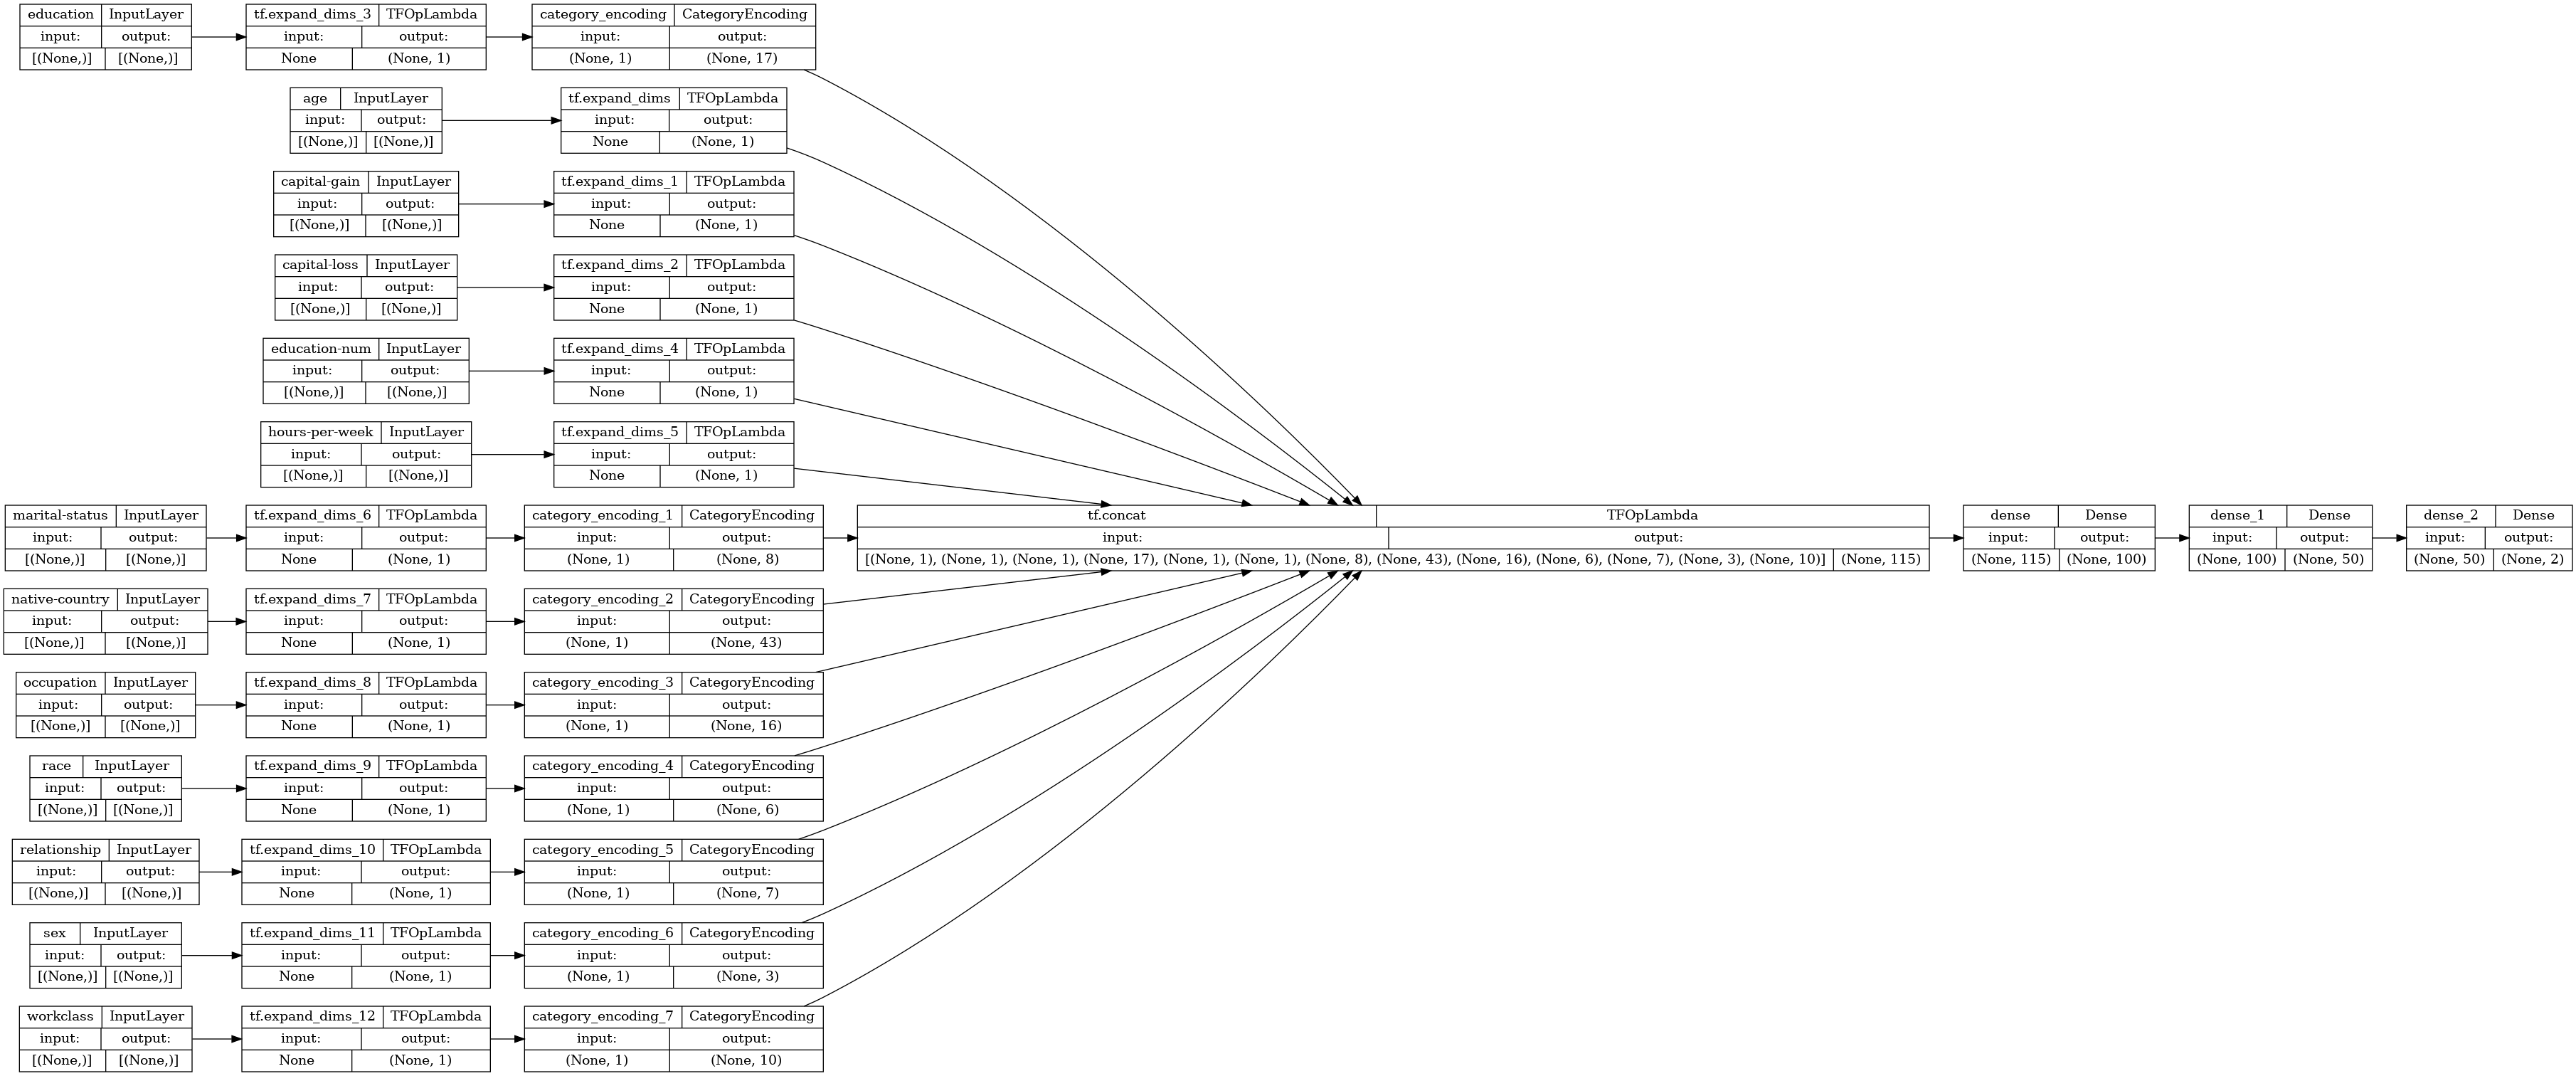

In [34]:
model = build_keras_model(output_dir)

tf_keras.utils.plot_model(model,rankdir='LR', show_shapes=True)

Build the datasets

In [35]:
def get_dataset(working_dir, filebase):
  tf_transform_output = tft.TFTransformOutput(working_dir)

  data_path_pattern = os.path.join(
      working_dir,
      filebase + '*')
  
  input_fn = _make_training_input_fn(
      tf_transform_output,
      data_path_pattern,
      batch_size=BATCH_SIZE)
  
  dataset = input_fn()

  return dataset

Train and evaluate the model:

In [36]:
def train_and_evaluate(
    model,
    working_dir):
  """Train the model on training data and evaluate on test data.

  Args:
    working_dir: The location of the Transform output.
    num_train_instances: Number of instances in train set
    num_test_instances: Number of instances in test set

  Returns:
    The results from the estimator's 'evaluate' method
  """
  train_dataset = get_dataset(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE)
  validation_dataset = get_dataset(working_dir, TRANSFORMED_TEST_DATA_FILEBASE)

  model = build_keras_model(working_dir)

  history = train_model(model, train_dataset, validation_dataset)

  metric_values = model.evaluate(validation_dataset,
                                 steps=EVALUATION_STEPS,
                                 return_dict=True)
  return model, history, metric_values

In [37]:
def train_model(model, train_dataset, validation_dataset):
  model.compile(optimizer='adam',
                loss=tf.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  history = model.fit(train_dataset, validation_data=validation_dataset,
      epochs=TRAIN_NUM_EPOCHS,
      steps_per_epoch=STEPS_PER_TRAIN_EPOCH,
      validation_steps=EVALUATION_STEPS)
  return history

In [38]:
model, history, metric_values = train_and_evaluate(model, output_dir)

Epoch 1/20


I0000 00:00:1714474167.542556  187132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/26 [>.............................] - ETA: 1:06 - loss: 0.6268 - accuracy: 0.7969

 2/26 [=>............................] - ETA: 17s - loss: 0.6099 - accuracy: 0.7930 

12/26 [============>.................] - ETA: 1s - loss: 0.5686 - accuracy: 0.7546 

23/26 [=========================>....] - ETA: 0s - loss: 0.5261 - accuracy: 0.7520

26/26 [==============================] - 4s 70ms/step - loss: 0.5136 - accuracy: 0.7578 - val_loss: 0.4207 - val_accuracy: 0.8198


Epoch 2/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3840 - accuracy: 0.8672

12/26 [============>.................] - ETA: 0s - loss: 0.4061 - accuracy: 0.8164

23/26 [=========================>....] - ETA: 0s - loss: 0.3916 - accuracy: 0.8203

26/26 [==============================] - 1s 27ms/step - loss: 0.3934 - accuracy: 0.8185 - val_loss: 0.3671 - val_accuracy: 0.8317


Epoch 3/20


 1/26 [>.............................] - ETA: 0s - loss: 0.4577 - accuracy: 0.7188

12/26 [============>.................] - ETA: 0s - loss: 0.3842 - accuracy: 0.8203

23/26 [=========================>....] - ETA: 0s - loss: 0.3713 - accuracy: 0.8271

26/26 [==============================] - 1s 27ms/step - loss: 0.3696 - accuracy: 0.8272 - val_loss: 0.3548 - val_accuracy: 0.8365


Epoch 4/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3406 - accuracy: 0.8281

12/26 [============>.................] - ETA: 0s - loss: 0.3441 - accuracy: 0.8359

23/26 [=========================>....] - ETA: 0s - loss: 0.3503 - accuracy: 0.8322

26/26 [==============================] - 1s 27ms/step - loss: 0.3499 - accuracy: 0.8314 - val_loss: 0.3528 - val_accuracy: 0.8383


Epoch 5/20


 1/26 [>.............................] - ETA: 0s - loss: 0.2875 - accuracy: 0.8828

12/26 [============>.................] - ETA: 0s - loss: 0.3582 - accuracy: 0.8366

23/26 [=========================>....] - ETA: 0s - loss: 0.3491 - accuracy: 0.8414

26/26 [==============================] - 1s 27ms/step - loss: 0.3503 - accuracy: 0.8401 - val_loss: 0.3478 - val_accuracy: 0.8408


Epoch 6/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3674 - accuracy: 0.8047

12/26 [============>.................] - ETA: 0s - loss: 0.3645 - accuracy: 0.8379

23/26 [=========================>....] - ETA: 0s - loss: 0.3573 - accuracy: 0.8393

26/26 [==============================] - 1s 27ms/step - loss: 0.3506 - accuracy: 0.8416 - val_loss: 0.3453 - val_accuracy: 0.8411


Epoch 7/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3709 - accuracy: 0.8359

12/26 [============>.................] - ETA: 0s - loss: 0.3641 - accuracy: 0.8268

23/26 [=========================>....] - ETA: 0s - loss: 0.3530 - accuracy: 0.8370

26/26 [==============================] - 1s 26ms/step - loss: 0.3511 - accuracy: 0.8380 - val_loss: 0.3430 - val_accuracy: 0.8410


Epoch 8/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3153 - accuracy: 0.8438

12/26 [============>.................] - ETA: 0s - loss: 0.3343 - accuracy: 0.8398

23/26 [=========================>....] - ETA: 0s - loss: 0.3344 - accuracy: 0.8444

26/26 [==============================] - 1s 27ms/step - loss: 0.3349 - accuracy: 0.8434 - val_loss: 0.3441 - val_accuracy: 0.8375


Epoch 9/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3535 - accuracy: 0.8750

12/26 [============>.................] - ETA: 0s - loss: 0.3579 - accuracy: 0.8281

23/26 [=========================>....] - ETA: 0s - loss: 0.3501 - accuracy: 0.8268

26/26 [==============================] - 1s 26ms/step - loss: 0.3473 - accuracy: 0.8296 - val_loss: 0.3390 - val_accuracy: 0.8425


Epoch 10/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3250 - accuracy: 0.8516

12/26 [============>.................] - ETA: 0s - loss: 0.3430 - accuracy: 0.8372

23/26 [=========================>....] - ETA: 0s - loss: 0.3393 - accuracy: 0.8393

26/26 [==============================] - 1s 27ms/step - loss: 0.3377 - accuracy: 0.8389 - val_loss: 0.3472 - val_accuracy: 0.8401


Epoch 11/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3444 - accuracy: 0.8281

12/26 [============>.................] - ETA: 0s - loss: 0.3164 - accuracy: 0.8581

23/26 [=========================>....] - ETA: 0s - loss: 0.3360 - accuracy: 0.8438

26/26 [==============================] - 1s 27ms/step - loss: 0.3446 - accuracy: 0.8383 - val_loss: 0.3403 - val_accuracy: 0.8413


Epoch 12/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3236 - accuracy: 0.8359

12/26 [============>.................] - ETA: 0s - loss: 0.3369 - accuracy: 0.8418

23/26 [=========================>....] - ETA: 0s - loss: 0.3334 - accuracy: 0.8475

26/26 [==============================] - 1s 26ms/step - loss: 0.3343 - accuracy: 0.8471 - val_loss: 0.3335 - val_accuracy: 0.8447


Epoch 13/20


 1/26 [>.............................] - ETA: 0s - loss: 0.4149 - accuracy: 0.7969

12/26 [============>.................] - ETA: 0s - loss: 0.3315 - accuracy: 0.8509

23/26 [=========================>....] - ETA: 0s - loss: 0.3315 - accuracy: 0.8533

26/26 [==============================] - 1s 27ms/step - loss: 0.3303 - accuracy: 0.8534 - val_loss: 0.3384 - val_accuracy: 0.8416


Epoch 14/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3209 - accuracy: 0.8828

12/26 [============>.................] - ETA: 0s - loss: 0.3383 - accuracy: 0.8353

23/26 [=========================>....] - ETA: 0s - loss: 0.3436 - accuracy: 0.8380

26/26 [==============================] - 1s 27ms/step - loss: 0.3400 - accuracy: 0.8407 - val_loss: 0.3340 - val_accuracy: 0.8453


Epoch 15/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3276 - accuracy: 0.8281

12/26 [============>.................] - ETA: 0s - loss: 0.3433 - accuracy: 0.8372

23/26 [=========================>....] - ETA: 0s - loss: 0.3417 - accuracy: 0.8387

26/26 [==============================] - 1s 27ms/step - loss: 0.3374 - accuracy: 0.8410 - val_loss: 0.3347 - val_accuracy: 0.8448


Epoch 16/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3220 - accuracy: 0.8438

12/26 [============>.................] - ETA: 0s - loss: 0.3243 - accuracy: 0.8529

23/26 [=========================>....] - ETA: 0s - loss: 0.3319 - accuracy: 0.8438

26/26 [==============================] - 1s 27ms/step - loss: 0.3279 - accuracy: 0.8459 - val_loss: 0.3326 - val_accuracy: 0.8450


Epoch 17/20


 1/26 [>.............................] - ETA: 0s - loss: 0.2650 - accuracy: 0.8906

12/26 [============>.................] - ETA: 0s - loss: 0.3065 - accuracy: 0.8620

23/26 [=========================>....] - ETA: 0s - loss: 0.3186 - accuracy: 0.8465

26/26 [==============================] - 1s 26ms/step - loss: 0.3184 - accuracy: 0.8474 - val_loss: 0.3341 - val_accuracy: 0.8447


Epoch 18/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3716 - accuracy: 0.8203

12/26 [============>.................] - ETA: 0s - loss: 0.3519 - accuracy: 0.8379

23/26 [=========================>....] - ETA: 0s - loss: 0.3414 - accuracy: 0.8393

26/26 [==============================] - 1s 26ms/step - loss: 0.3393 - accuracy: 0.8410 - val_loss: 0.3332 - val_accuracy: 0.8433


Epoch 19/20


 1/26 [>.............................] - ETA: 0s - loss: 0.2747 - accuracy: 0.8828

12/26 [============>.................] - ETA: 0s - loss: 0.3432 - accuracy: 0.8379

23/26 [=========================>....] - ETA: 0s - loss: 0.3368 - accuracy: 0.8373

26/26 [==============================] - 1s 26ms/step - loss: 0.3356 - accuracy: 0.8368 - val_loss: 0.3300 - val_accuracy: 0.8454


Epoch 20/20


 1/26 [>.............................] - ETA: 0s - loss: 0.3878 - accuracy: 0.7969

12/26 [============>.................] - ETA: 0s - loss: 0.3318 - accuracy: 0.8424

23/26 [=========================>....] - ETA: 0s - loss: 0.3261 - accuracy: 0.8434

26/26 [==============================] - 1s 27ms/step - loss: 0.3283 - accuracy: 0.8438 - val_loss: 0.3298 - val_accuracy: 0.8434


  1/128 [..............................] - ETA: 14s - loss: 0.3578 - accuracy: 0.8281

 14/128 [==>...........................] - ETA: 0s - loss: 0.3480 - accuracy: 0.8343 

 28/128 [=====>........................] - ETA: 0s - loss: 0.3394 - accuracy: 0.8359

 40/128 [========>.....................] - ETA: 0s - loss: 0.3387 - accuracy: 0.8348

 53/128 [===========>..................] - ETA: 0s - loss: 0.3374 - accuracy: 0.8345

 66/128 [==============>...............] - ETA: 0s - loss: 0.3349 - accuracy: 0.8369

 79/128 [=================>............] - ETA: 0s - loss: 0.3360 - accuracy: 0.8377

 92/128 [====================>.........] - ETA: 0s - loss: 0.3362 - accuracy: 0.8392

106/128 [=======================>......] - ETA: 0s - loss: 0.3323 - accuracy: 0.8417

119/128 [==========================>...] - ETA: 0s - loss: 0.3319 - accuracy: 0.8424

128/128 [==============================] - 1s 4ms/step - loss: 0.3303 - accuracy: 0.8433


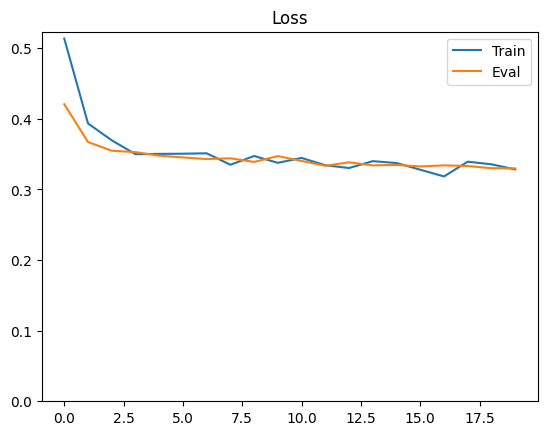

In [39]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Eval')
plt.ylim(0,max(plt.ylim()))
plt.legend()
plt.title('Loss');

### Transform new data

In the previous section the training process used the hard-copies of the transformed data that were generated by `tft_beam.AnalyzeAndTransformDataset` in the `transform_dataset` function. 

For operating on new data you'll need to load final version of the `preprocessing_fn` that was saved by `tft_beam.WriteTransformFn`. 

The `TFTransformOutput.transform_features_layer` method loads the `preprocessing_fn` SavedModel from the output directory.

Here's a function to load new, unprocessed batches from a source file:

In [40]:
def read_csv(file_name, batch_size):
  return tf.data.experimental.make_csv_dataset(
        file_pattern=file_name,
        batch_size=batch_size,
        column_names=ORDERED_CSV_COLUMNS,
        column_defaults=COLUMN_DEFAULTS,
        prefetch_buffer_size=0,
        ignore_errors=True)

In [41]:
for ex in read_csv(test_path, batch_size=5):
  break

pd.DataFrame(ex)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


age      workclass    fnlwgt         education  education-num  \
0  35.0    b' Private'  194404.0     b' Bachelors'           13.0   
1  36.0    b' Private'  161141.0       b' Masters'           14.0   
2  22.0          b' ?'  166297.0  b' Some-college'           10.0   
3  64.0    b' Private'  137135.0       b' HS-grad'            9.0   
4  40.0  b' Local-gov'  225660.0     b' Bachelors'           13.0   

           marital-status             occupation       relationship  \
0  b' Married-civ-spouse'     b' Prof-specialty'        b' Husband'   
1  b' Married-civ-spouse'     b' Prof-specialty'        b' Husband'   
2       b' Never-married'                  b' ?'      b' Own-child'   
3  b' Married-civ-spouse'  b' Machine-op-inspct'        b' Husband'   
4       b' Never-married'    b' Protective-serv'  b' Not-in-family'   

                     race         sex  capital-gain  capital-loss  \
0               b' White'    b' Male'           0.0           0.0   
1               b' White'    b' Male'           0.0           0.0   
2  b' Asian-Pac-Islander'    b' Male'           0.0           0.0   
3               b' White'    b' Male'           0.0           0.0   
4               b' White'  b' Female'           0.0           0.0   

   hours-per-week     native-country       label  
0            40.0  b' United-States'   b' >50K.'  
1            50.0  b' United-States'   b' >50K.'  
2            20.0  b' United-States'  b' <=50K.'  
3            48.0  b' United-States'  b' <=50K.'  
4            40.0  b' United-States'  b' <=50K.'

Load the `tft.TransformFeaturesLayer` to transform this data with the `preprocessing_fn`:

In [42]:
ex2 = ex.copy()
ex2.pop('fnlwgt')

tft_layer = tf_transform_output.transform_features_layer()
t_ex = tft_layer(ex2)

label = t_ex.pop(LABEL_KEY)
pd.DataFrame(t_ex)

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


capital-loss  sex  capital-gain  marital-status       age  race  \
0           0.0    0           0.0               0  0.246575     0   
1           0.0    0           0.0               0  0.260274     0   
2           0.0    0           0.0               1  0.068493     2   
3           0.0    0           0.0               0  0.643836     0   
4           0.0    1           0.0               1  0.315068     0   

   relationship  hours-per-week  education-num  native-country  education  \
0             0        0.397959       0.800000               0          2   
1             0        0.500000       0.866667               0          3   
2             2        0.193878       0.600000               0          1   
3             0        0.479592       0.533333               0          0   
4             1        0.397959       0.800000               0          2   

   workclass  occupation  
0          0           0  
1          0           0  
2          3           7  
3          0           6  
4          2          12

The `tft_layer` is smart enough to still execute the transformation if only a subset of features are passed in. For example, if you only pass in two features, you'll get just the transformed versions of those features back: 

In [43]:
ex2 = pd.DataFrame(ex)[['education', 'hours-per-week']]
ex2

education  hours-per-week
0     b' Bachelors'            40.0
1       b' Masters'            50.0
2  b' Some-college'            20.0
3       b' HS-grad'            48.0
4     b' Bachelors'            40.0

In [44]:
pd.DataFrame(tft_layer(dict(ex2)))

hours-per-week  education
0        0.397959          2
1        0.500000          3
2        0.193878          1
3        0.479592          0
4        0.397959          2

Here's a more robust version that drops features that are not in the feature-spec, and returns a `(features, label)` pair if the label is in the provided features:

In [45]:
class Transform(tf.Module):
  def __init__(self, working_dir):
    self.working_dir = working_dir
    self.tf_transform_output = tft.TFTransformOutput(working_dir)
    self.tft_layer = tf_transform_output.transform_features_layer()
  
  @tf.function
  def __call__(self, features):
    raw_features = {}

    for key, val in features.items():
      # Skip unused keys
      if key not in RAW_DATA_FEATURE_SPEC:
        continue

      raw_features[key] = val

    # Apply the `preprocessing_fn`.
    transformed_features = tft_layer(raw_features)
    
    if LABEL_KEY in transformed_features:
      # Pop the label and return a (features, labels) pair.
      data_labels = transformed_features.pop(LABEL_KEY)
      return (transformed_features, data_labels)
    else:
      return transformed_features


In [46]:
transform = Transform(output_dir)

In [47]:
t_ex, t_label = transform(ex)

In [48]:
pd.DataFrame(t_ex)

capital-loss  sex  capital-gain  marital-status       age  race  \
0           0.0    0           0.0               0  0.246575     0   
1           0.0    0           0.0               0  0.260274     0   
2           0.0    0           0.0               1  0.068493     2   
3           0.0    0           0.0               0  0.643836     0   
4           0.0    1           0.0               1  0.315068     0   

   relationship  hours-per-week  education-num  native-country  education  \
0             0        0.397959       0.800000               0          2   
1             0        0.500000       0.866667               0          3   
2             2        0.193878       0.600000               0          1   
3             0        0.479592       0.533333               0          0   
4             1        0.397959       0.800000               0          2   

   workclass  occupation  
0          0           0  
1          0           0  
2          3           7  
3          0           6  
4          2          12

Now you can use `Dataset.map` to apply that transformation, on the fly to new data:

In [49]:
model.evaluate(
    read_csv(test_path, batch_size=5).map(transform),
    steps=EVALUATION_STEPS,
    return_dict=True
)

  1/128 [..............................] - ETA: 1:25 - loss: 0.2619 - accuracy: 1.0000

 12/128 [=>............................] - ETA: 0s - loss: 0.2226 - accuracy: 0.9500  

 24/128 [====>.........................] - ETA: 0s - loss: 0.3279 - accuracy: 0.8583

 36/128 [=======>......................] - ETA: 0s - loss: 0.3275 - accuracy: 0.8556

 48/128 [==========>...................] - ETA: 0s - loss: 0.3145 - accuracy: 0.8625

 60/128 [=============>................] - ETA: 0s - loss: 0.3020 - accuracy: 0.8667

 72/128 [===============>..............] - ETA: 0s - loss: 0.2982 - accuracy: 0.8639

 84/128 [==================>...........] - ETA: 0s - loss: 0.2919 - accuracy: 0.8690

 96/128 [=====================>........] - ETA: 0s - loss: 0.2917 - accuracy: 0.8625

108/128 [========================>.....] - ETA: 0s - loss: 0.2897 - accuracy: 0.8648

120/128 [===========================>..] - ETA: 0s - loss: 0.3011 - accuracy: 0.8567

128/128 [==============================] - 1s 4ms/step - loss: 0.2992 - accuracy: 0.8547


{'loss': 0.2991926074028015, 'accuracy': 0.854687511920929}

### Export the model

So you have a trained model, and a method to apply the `preprocessing_fn` to new data. Assemble them into a new model that accepts serialized `tf.train.Example` protos as input.

In [50]:
class ServingModel(tf.Module):
  def __init__(self, model, working_dir):
    self.model = model
    self.working_dir = working_dir
    self.transform = Transform(working_dir)

  @tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string)])
  def __call__(self, serialized_tf_examples):
    # parse the tf.train.Example
    feature_spec = RAW_DATA_FEATURE_SPEC.copy()
    feature_spec.pop(LABEL_KEY)
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
    # Apply the `preprocessing_fn`
    transformed_features = self.transform(parsed_features)
    # Run the model
    outputs = self.model(transformed_features)
    # Format the output
    classes_names = tf.constant([['0', '1']])
    classes = tf.tile(classes_names, [tf.shape(outputs)[0], 1])
    return {'classes': classes, 'scores': outputs}

  def export(self, output_dir):
    # Increment the directory number. This is required in order to make this
    # model servable with model_server.
    save_model_dir = pathlib.Path(output_dir)/'model'
    number_dirs = [int(p.name) for p in save_model_dir.glob('*')
                  if p.name.isdigit()]
    id = max([0] + number_dirs)+1
    save_model_dir = save_model_dir/str(id)

    # Set the signature to make it visible for serving.
    concrete_serving_fn = self.__call__.get_concrete_function()
    signatures = {'serving_default': concrete_serving_fn}

    # Export the model.
    tf.saved_model.save(
        self,
        str(save_model_dir),
        signatures=signatures)
    
    return save_model_dir

Build the model and test-run it on the batch of serialized examples:

In [51]:
serving_model = ServingModel(model, output_dir)

serving_model(serialized_example_batch)

{'classes': <tf.Tensor: shape=(3, 2), dtype=string, numpy=
 array([[b'0', b'1'],
        [b'0', b'1'],
        [b'0', b'1']], dtype=object)>,
 'scores': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-1.6049761e+00,  9.7535902e-01],
        [-5.3329688e-01, -1.6330201e-03],
        [-1.8765860e+00,  1.5198938e+00]], dtype=float32)>}

Export the model as a SavedModel:

In [52]:
saved_model_dir = serving_model.export(output_dir)
saved_model_dir

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpckiw2b8s/keras/model/1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpckiw2b8s/keras/model/1/assets


PosixPath('/tmpfs/tmp/tmpckiw2b8s/keras/model/1')

Reload the model and test it on the same batch of examples:

In [53]:
reloaded = tf.saved_model.load(str(saved_model_dir))
run_model = reloaded.signatures['serving_default']

In [54]:
run_model(serialized_example_batch)

{'classes': <tf.Tensor: shape=(3, 2), dtype=string, numpy=
 array([[b'0', b'1'],
        [b'0', b'1'],
        [b'0', b'1']], dtype=object)>,
 'scores': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-1.6049761e+00,  9.7535902e-01],
        [-5.3329688e-01, -1.6330201e-03],
        [-1.8765860e+00,  1.5198938e+00]], dtype=float32)>}

##What we did
In this example we used `tf.Transform` to preprocess a dataset of census data, and train a model with the cleaned and transformed data.  We also created an input function that we could use when we deploy our trained model in a production environment to perform inference.  By using the same code for both training and inference we avoid any issues with data skew.  Along the way we learned about creating an Apache Beam transform to perform the transformation that we needed for cleaning the data. We also saw how to use this transformed data to train a model using `tf_keras`.  This is just a small piece of what TensorFlow Transform can do!  We encourage you to dive into `tf.Transform` and discover what it can do for you.

## [Optional] Using our preprocessed data to train a model using tf.estimator

> Warning: Estimators are not recommended for new code.  Estimators run
<a href="https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session"><code>v1.Session</code></a>-style code which is more difficult to write correctly, and
can behave unexpectedly, especially when combined with TF 2 code. Estimators
do fall under our
[compatibility guarantees](https://tensorflow.org/guide/versions), but will
receive no fixes other than security vulnerabilities. See the
[migration guide](https://tensorflow.org/guide/migrate) for details.

 <!-- <div class="tfo-display-only-on-site"><devsite-expandable>
  <button type="button" class="button-red button expand-control">Show Section</button> -->


###Create an input function for training

In [55]:
def _make_training_input_fn(tf_transform_output, transformed_examples,
                            batch_size):
  """Creates an input function reading from transformed data.

  Args:
    tf_transform_output: Wrapper around output of tf.Transform.
    transformed_examples: Base filename of examples.
    batch_size: Batch size.

  Returns:
    The input function for training or eval.
  """
  def input_fn():
    """Input function for training and eval."""
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=transformed_examples,
        batch_size=batch_size,
        features=tf_transform_output.transformed_feature_spec(),
        reader=tf.data.TFRecordDataset,
        shuffle=True)

    transformed_features = tf.compat.v1.data.make_one_shot_iterator(
        dataset).get_next()

    # Extract features and label from the transformed tensors.
    transformed_labels = tf.where(
        tf.equal(transformed_features.pop(LABEL_KEY), 1))

    return transformed_features, transformed_labels[:,1]

  return input_fn

###Create an input function for serving

Let's create an input function that we could use in production, and prepare our trained model for serving.

In [56]:
def _make_serving_input_fn(tf_transform_output):
  """Creates an input function reading from raw data.

  Args:
    tf_transform_output: Wrapper around output of tf.Transform.

  Returns:
    The serving input function.
  """
  raw_feature_spec = RAW_DATA_FEATURE_SPEC.copy()
  # Remove label since it is not available during serving.
  raw_feature_spec.pop(LABEL_KEY)

  def serving_input_fn():
    """Input function for serving."""
    # Get raw features by generating the basic serving input_fn and calling it.
    # Here we generate an input_fn that expects a parsed Example proto to be fed
    # to the model at serving time.  See also
    # tf.estimator.export.build_raw_serving_input_receiver_fn.
    raw_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
        raw_feature_spec, default_batch_size=None)
    serving_input_receiver = raw_input_fn()

    # Apply the transform function that was used to generate the materialized
    # data.
    raw_features = serving_input_receiver.features
    transformed_features = tf_transform_output.transform_raw_features(
        raw_features)

    return tf.estimator.export.ServingInputReceiver(
        transformed_features, serving_input_receiver.receiver_tensors)

  return serving_input_fn

###Wrap our input data in FeatureColumns
Our model will expect our data in TensorFlow FeatureColumns.

In [57]:
def get_feature_columns(tf_transform_output):
  """Returns the FeatureColumns for the model.

  Args:
    tf_transform_output: A `TFTransformOutput` object.

  Returns:
    A list of FeatureColumns.
  """
  # Wrap scalars as real valued columns.
  real_valued_columns = [tf.feature_column.numeric_column(key, shape=())
                         for key in NUMERIC_FEATURE_KEYS]

  # Wrap categorical columns.
  one_hot_columns = [
      tf.feature_column.indicator_column(
          tf.feature_column.categorical_column_with_identity(
              key=key,
              num_buckets=(NUM_OOV_BUCKETS +
                  tf_transform_output.vocabulary_size_by_name(
                      vocab_filename=key))))
      for key in CATEGORICAL_FEATURE_KEYS]

  return real_valued_columns + one_hot_columns

###Train, Evaluate, and Export our model

In [58]:
def train_and_evaluate(working_dir, num_train_instances=NUM_TRAIN_INSTANCES,
                       num_test_instances=NUM_TEST_INSTANCES):
  """Train the model on training data and evaluate on test data.

  Args:
    working_dir: Directory to read transformed data and metadata from and to
        write exported model to.
    num_train_instances: Number of instances in train set
    num_test_instances: Number of instances in test set

  Returns:
    The results from the estimator's 'evaluate' method
  """
  tf_transform_output = tft.TFTransformOutput(working_dir)

  run_config = tf.estimator.RunConfig()

  estimator = tf.estimator.LinearClassifier(
      feature_columns=get_feature_columns(tf_transform_output),
      config=run_config,
      loss_reduction=tf.losses.Reduction.SUM)

  # Fit the model using the default optimizer.
  train_input_fn = _make_training_input_fn(
      tf_transform_output,
      os.path.join(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE + '*'),
      batch_size=BATCH_SIZE)
  estimator.train(
      input_fn=train_input_fn,
      max_steps=TRAIN_NUM_EPOCHS * num_train_instances / BATCH_SIZE)

  # Evaluate model on test dataset.
  eval_input_fn = _make_training_input_fn(
      tf_transform_output,
      os.path.join(working_dir, TRANSFORMED_TEST_DATA_FILEBASE + '*'),
      batch_size=1)

  # Export the model.
  serving_input_fn = _make_serving_input_fn(tf_transform_output)
  exported_model_dir = os.path.join(working_dir, EXPORTED_MODEL_DIR)
  estimator.export_saved_model(exported_model_dir, serving_input_fn)

  return estimator.evaluate(input_fn=eval_input_fn, steps=num_test_instances)

###Put it all together
We've created all the stuff we need to preprocess our census data, train a model, and prepare it for serving.  So far we've just been getting things ready.  It's time to start running!

Note: Scroll the output from this cell to see the whole process.  The results will be at the bottom.

In [59]:
import tempfile
temp = temp = os.path.join(tempfile.mkdtemp(),'estimator')

transform_data(train_path, test_path, temp)
results = train_and_evaluate(temp)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvfol9yyw/tftransform_tmp/7f57f74495a24870877a207197967bb1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvfol9yyw/tftransform_tmp/7f57f74495a24870877a207197967bb1/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvfol9yyw/tftransform_tmp/50532d4a7a7844099ecd59a9a8bb3b64/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpvfol9yyw/tftransform_tmp/50532d4a7a7844099ecd59a9a8bb3b64/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Using config: {'_model_dir': '/tmpfs/tmp/tmp5z0b2qd4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmpfs/tmp/tmp5z0b2qd4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmpfs/tmp/tmp5z0b2qd4/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmpfs/tmp/tmp5z0b2qd4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:loss = 88.72284, step = 0


INFO:tensorflow:loss = 88.72284, step = 0


INFO:tensorflow:global_step/sec: 217.048


INFO:tensorflow:global_step/sec: 217.048


INFO:tensorflow:loss = 38.05179, step = 100 (0.463 sec)


INFO:tensorflow:loss = 38.05179, step = 100 (0.463 sec)


INFO:tensorflow:global_step/sec: 309.278


INFO:tensorflow:global_step/sec: 309.278


INFO:tensorflow:loss = 62.872578, step = 200 (0.323 sec)


INFO:tensorflow:loss = 62.872578, step = 200 (0.323 sec)


INFO:tensorflow:global_step/sec: 306.322


INFO:tensorflow:global_step/sec: 306.322


INFO:tensorflow:loss = 43.058277, step = 300 (0.327 sec)


INFO:tensorflow:loss = 43.058277, step = 300 (0.327 sec)


INFO:tensorflow:global_step/sec: 307.682


INFO:tensorflow:global_step/sec: 307.682


INFO:tensorflow:loss = 33.610596, step = 400 (0.325 sec)


INFO:tensorflow:loss = 33.610596, step = 400 (0.325 sec)


INFO:tensorflow:global_step/sec: 306.892


INFO:tensorflow:global_step/sec: 306.892


INFO:tensorflow:loss = 49.49376, step = 500 (0.326 sec)


INFO:tensorflow:loss = 49.49376, step = 500 (0.326 sec)


INFO:tensorflow:global_step/sec: 309.289


INFO:tensorflow:global_step/sec: 309.289


INFO:tensorflow:loss = 39.562958, step = 600 (0.323 sec)


INFO:tensorflow:loss = 39.562958, step = 600 (0.323 sec)


INFO:tensorflow:global_step/sec: 311.884


INFO:tensorflow:global_step/sec: 311.884


INFO:tensorflow:loss = 39.649498, step = 700 (0.320 sec)


INFO:tensorflow:loss = 39.649498, step = 700 (0.320 sec)


INFO:tensorflow:global_step/sec: 311.451


INFO:tensorflow:global_step/sec: 311.451


INFO:tensorflow:loss = 40.63858, step = 800 (0.321 sec)


INFO:tensorflow:loss = 40.63858, step = 800 (0.321 sec)


INFO:tensorflow:global_step/sec: 310.801


INFO:tensorflow:global_step/sec: 310.801


INFO:tensorflow:loss = 56.933117, step = 900 (0.322 sec)


INFO:tensorflow:loss = 56.933117, step = 900 (0.322 sec)


INFO:tensorflow:global_step/sec: 310.947


INFO:tensorflow:global_step/sec: 310.947


INFO:tensorflow:loss = 43.414566, step = 1000 (0.321 sec)


INFO:tensorflow:loss = 43.414566, step = 1000 (0.321 sec)


INFO:tensorflow:global_step/sec: 307.503


INFO:tensorflow:global_step/sec: 307.503


INFO:tensorflow:loss = 46.722263, step = 1100 (0.326 sec)


INFO:tensorflow:loss = 46.722263, step = 1100 (0.326 sec)


INFO:tensorflow:global_step/sec: 310.43


INFO:tensorflow:global_step/sec: 310.43


INFO:tensorflow:loss = 42.71798, step = 1200 (0.322 sec)


INFO:tensorflow:loss = 42.71798, step = 1200 (0.322 sec)


INFO:tensorflow:global_step/sec: 306.606


INFO:tensorflow:global_step/sec: 306.606


INFO:tensorflow:loss = 32.245277, step = 1300 (0.326 sec)


INFO:tensorflow:loss = 32.245277, step = 1300 (0.326 sec)


INFO:tensorflow:global_step/sec: 304.767


INFO:tensorflow:global_step/sec: 304.767


INFO:tensorflow:loss = 39.286648, step = 1400 (0.328 sec)


INFO:tensorflow:loss = 39.286648, step = 1400 (0.328 sec)


INFO:tensorflow:global_step/sec: 311.309


INFO:tensorflow:global_step/sec: 311.309


INFO:tensorflow:loss = 47.270004, step = 1500 (0.321 sec)


INFO:tensorflow:loss = 47.270004, step = 1500 (0.321 sec)


INFO:tensorflow:global_step/sec: 312.664


INFO:tensorflow:global_step/sec: 312.664


INFO:tensorflow:loss = 41.641903, step = 1600 (0.320 sec)


INFO:tensorflow:loss = 41.641903, step = 1600 (0.320 sec)


INFO:tensorflow:global_step/sec: 314.642


INFO:tensorflow:global_step/sec: 314.642


INFO:tensorflow:loss = 39.352055, step = 1700 (0.318 sec)


INFO:tensorflow:loss = 39.352055, step = 1700 (0.318 sec)


INFO:tensorflow:global_step/sec: 308.436


INFO:tensorflow:global_step/sec: 308.436


INFO:tensorflow:loss = 42.981514, step = 1800 (0.324 sec)


INFO:tensorflow:loss = 42.981514, step = 1800 (0.324 sec)


INFO:tensorflow:global_step/sec: 304.007


INFO:tensorflow:global_step/sec: 304.007


INFO:tensorflow:loss = 39.558506, step = 1900 (0.329 sec)


INFO:tensorflow:loss = 39.558506, step = 1900 (0.329 sec)


INFO:tensorflow:global_step/sec: 308.174


INFO:tensorflow:global_step/sec: 308.174


INFO:tensorflow:loss = 36.912056, step = 2000 (0.325 sec)


INFO:tensorflow:loss = 36.912056, step = 2000 (0.325 sec)


INFO:tensorflow:global_step/sec: 305.635


INFO:tensorflow:global_step/sec: 305.635


INFO:tensorflow:loss = 50.084297, step = 2100 (0.327 sec)


INFO:tensorflow:loss = 50.084297, step = 2100 (0.327 sec)


INFO:tensorflow:global_step/sec: 304.925


INFO:tensorflow:global_step/sec: 304.925


INFO:tensorflow:loss = 34.076836, step = 2200 (0.328 sec)


INFO:tensorflow:loss = 34.076836, step = 2200 (0.328 sec)


INFO:tensorflow:global_step/sec: 304.67


INFO:tensorflow:global_step/sec: 304.67


INFO:tensorflow:loss = 42.80255, step = 2300 (0.328 sec)


INFO:tensorflow:loss = 42.80255, step = 2300 (0.328 sec)


INFO:tensorflow:global_step/sec: 304.428


INFO:tensorflow:global_step/sec: 304.428


INFO:tensorflow:loss = 43.28376, step = 2400 (0.328 sec)


INFO:tensorflow:loss = 43.28376, step = 2400 (0.328 sec)


INFO:tensorflow:global_step/sec: 306.855


INFO:tensorflow:global_step/sec: 306.855


INFO:tensorflow:loss = 52.975185, step = 2500 (0.326 sec)


INFO:tensorflow:loss = 52.975185, step = 2500 (0.326 sec)


INFO:tensorflow:global_step/sec: 301.499


INFO:tensorflow:global_step/sec: 301.499


INFO:tensorflow:loss = 38.57332, step = 2600 (0.332 sec)


INFO:tensorflow:loss = 38.57332, step = 2600 (0.332 sec)


INFO:tensorflow:global_step/sec: 304.658


INFO:tensorflow:global_step/sec: 304.658


INFO:tensorflow:loss = 42.026337, step = 2700 (0.328 sec)


INFO:tensorflow:loss = 42.026337, step = 2700 (0.328 sec)


INFO:tensorflow:global_step/sec: 304.471


INFO:tensorflow:global_step/sec: 304.471


INFO:tensorflow:loss = 49.812424, step = 2800 (0.329 sec)


INFO:tensorflow:loss = 49.812424, step = 2800 (0.329 sec)


INFO:tensorflow:global_step/sec: 301.243


INFO:tensorflow:global_step/sec: 301.243


INFO:tensorflow:loss = 38.365997, step = 2900 (0.332 sec)


INFO:tensorflow:loss = 38.365997, step = 2900 (0.332 sec)


INFO:tensorflow:global_step/sec: 303.047


INFO:tensorflow:global_step/sec: 303.047


INFO:tensorflow:loss = 46.136482, step = 3000 (0.330 sec)


INFO:tensorflow:loss = 46.136482, step = 3000 (0.330 sec)


INFO:tensorflow:global_step/sec: 309.327


INFO:tensorflow:global_step/sec: 309.327


INFO:tensorflow:loss = 39.838882, step = 3100 (0.323 sec)


INFO:tensorflow:loss = 39.838882, step = 3100 (0.323 sec)


INFO:tensorflow:global_step/sec: 314.267


INFO:tensorflow:global_step/sec: 314.267


INFO:tensorflow:loss = 41.79177, step = 3200 (0.318 sec)


INFO:tensorflow:loss = 41.79177, step = 3200 (0.318 sec)


INFO:tensorflow:global_step/sec: 301.294


INFO:tensorflow:global_step/sec: 301.294


INFO:tensorflow:loss = 41.994194, step = 3300 (0.332 sec)


INFO:tensorflow:loss = 41.994194, step = 3300 (0.332 sec)


INFO:tensorflow:global_step/sec: 308.412


INFO:tensorflow:global_step/sec: 308.412


INFO:tensorflow:loss = 41.158104, step = 3400 (0.324 sec)


INFO:tensorflow:loss = 41.158104, step = 3400 (0.324 sec)


INFO:tensorflow:global_step/sec: 305.302


INFO:tensorflow:global_step/sec: 305.302


INFO:tensorflow:loss = 35.35069, step = 3500 (0.328 sec)


INFO:tensorflow:loss = 35.35069, step = 3500 (0.328 sec)


INFO:tensorflow:global_step/sec: 303.808


INFO:tensorflow:global_step/sec: 303.808


INFO:tensorflow:loss = 49.999313, step = 3600 (0.329 sec)


INFO:tensorflow:loss = 49.999313, step = 3600 (0.329 sec)


INFO:tensorflow:global_step/sec: 312.812


INFO:tensorflow:global_step/sec: 312.812


INFO:tensorflow:loss = 44.52297, step = 3700 (0.320 sec)


INFO:tensorflow:loss = 44.52297, step = 3700 (0.320 sec)


INFO:tensorflow:global_step/sec: 311.422


INFO:tensorflow:global_step/sec: 311.422


INFO:tensorflow:loss = 31.237823, step = 3800 (0.321 sec)


INFO:tensorflow:loss = 31.237823, step = 3800 (0.321 sec)


INFO:tensorflow:global_step/sec: 311.942


INFO:tensorflow:global_step/sec: 311.942


INFO:tensorflow:loss = 40.837013, step = 3900 (0.321 sec)


INFO:tensorflow:loss = 40.837013, step = 3900 (0.321 sec)


INFO:tensorflow:global_step/sec: 310.278


INFO:tensorflow:global_step/sec: 310.278


INFO:tensorflow:loss = 48.289017, step = 4000 (0.322 sec)


INFO:tensorflow:loss = 48.289017, step = 4000 (0.322 sec)


INFO:tensorflow:global_step/sec: 305.809


INFO:tensorflow:global_step/sec: 305.809


INFO:tensorflow:loss = 42.82827, step = 4100 (0.327 sec)


INFO:tensorflow:loss = 42.82827, step = 4100 (0.327 sec)


INFO:tensorflow:global_step/sec: 309.371


INFO:tensorflow:global_step/sec: 309.371


INFO:tensorflow:loss = 49.08073, step = 4200 (0.323 sec)


INFO:tensorflow:loss = 49.08073, step = 4200 (0.323 sec)


INFO:tensorflow:global_step/sec: 313.159


INFO:tensorflow:global_step/sec: 313.159


INFO:tensorflow:loss = 43.150997, step = 4300 (0.319 sec)


INFO:tensorflow:loss = 43.150997, step = 4300 (0.319 sec)


INFO:tensorflow:global_step/sec: 317.596


INFO:tensorflow:global_step/sec: 317.596


INFO:tensorflow:loss = 46.704082, step = 4400 (0.315 sec)


INFO:tensorflow:loss = 46.704082, step = 4400 (0.315 sec)


INFO:tensorflow:global_step/sec: 316.261


INFO:tensorflow:global_step/sec: 316.261


INFO:tensorflow:loss = 42.477634, step = 4500 (0.316 sec)


INFO:tensorflow:loss = 42.477634, step = 4500 (0.316 sec)


INFO:tensorflow:global_step/sec: 319.902


INFO:tensorflow:global_step/sec: 319.902


INFO:tensorflow:loss = 47.049324, step = 4600 (0.313 sec)


INFO:tensorflow:loss = 47.049324, step = 4600 (0.313 sec)


INFO:tensorflow:global_step/sec: 323.097


INFO:tensorflow:global_step/sec: 323.097


INFO:tensorflow:loss = 28.26455, step = 4700 (0.310 sec)


INFO:tensorflow:loss = 28.26455, step = 4700 (0.310 sec)


INFO:tensorflow:global_step/sec: 318.749


INFO:tensorflow:global_step/sec: 318.749


INFO:tensorflow:loss = 30.772062, step = 4800 (0.314 sec)


INFO:tensorflow:loss = 30.772062, step = 4800 (0.314 sec)


INFO:tensorflow:global_step/sec: 323.13


INFO:tensorflow:global_step/sec: 323.13


INFO:tensorflow:loss = 42.176075, step = 4900 (0.310 sec)


INFO:tensorflow:loss = 42.176075, step = 4900 (0.310 sec)


INFO:tensorflow:global_step/sec: 321.773


INFO:tensorflow:global_step/sec: 321.773


INFO:tensorflow:loss = 52.00352, step = 5000 (0.311 sec)


INFO:tensorflow:loss = 52.00352, step = 5000 (0.311 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5088...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5088...


INFO:tensorflow:Saving checkpoints for 5088 into /tmpfs/tmp/tmp5z0b2qd4/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5088 into /tmpfs/tmp/tmp5z0b2qd4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5088...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5088...


INFO:tensorflow:Loss for final step: 33.25688.


INFO:tensorflow:Loss for final step: 33.25688.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']


INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']


INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']


INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from /tmpfs/tmp/tmp5z0b2qd4/model.ckpt-5088


INFO:tensorflow:Restoring parameters from /tmpfs/tmp/tmp5z0b2qd4/model.ckpt-5088


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp4ti4zdkp/estimator/exported_model_dir/temp-1714474233/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp4ti4zdkp/estimator/exported_model_dir/temp-1714474233/assets


INFO:tensorflow:SavedModel written to: /tmpfs/tmp/tmp4ti4zdkp/estimator/exported_model_dir/temp-1714474233/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmpfs/tmp/tmp4ti4zdkp/estimator/exported_model_dir/temp-1714474233/saved_model.pb


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2024-04-30T10:50:35


INFO:tensorflow:Starting evaluation at 2024-04-30T10:50:35


Instructions for updating:
Use tf.keras instead.


Instructions for updating:
Use tf.keras instead.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmpfs/tmp/tmp5z0b2qd4/model.ckpt-5088


INFO:tensorflow:Restoring parameters from /tmpfs/tmp/tmp5z0b2qd4/model.ckpt-5088


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1628/16280]


INFO:tensorflow:Evaluation [1628/16280]


INFO:tensorflow:Evaluation [3256/16280]


INFO:tensorflow:Evaluation [3256/16280]


INFO:tensorflow:Evaluation [4884/16280]


INFO:tensorflow:Evaluation [4884/16280]


INFO:tensorflow:Evaluation [6512/16280]


INFO:tensorflow:Evaluation [6512/16280]


INFO:tensorflow:Evaluation [8140/16280]


INFO:tensorflow:Evaluation [8140/16280]


INFO:tensorflow:Evaluation [9768/16280]


INFO:tensorflow:Evaluation [9768/16280]


INFO:tensorflow:Evaluation [11396/16280]


INFO:tensorflow:Evaluation [11396/16280]


INFO:tensorflow:Evaluation [13024/16280]


INFO:tensorflow:Evaluation [13024/16280]


INFO:tensorflow:Evaluation [14652/16280]


INFO:tensorflow:Evaluation [14652/16280]


INFO:tensorflow:Evaluation [16280/16280]


INFO:tensorflow:Evaluation [16280/16280]


INFO:tensorflow:Inference Time : 49.09539s


INFO:tensorflow:Inference Time : 49.09539s


INFO:tensorflow:Finished evaluation at 2024-04-30-10:51:24


INFO:tensorflow:Finished evaluation at 2024-04-30-10:51:24


INFO:tensorflow:Saving dict for global step 5088: accuracy = 0.85110563, accuracy_baseline = 0.7637592, auc = 0.90211606, auc_precision_recall = 0.96728647, average_loss = 0.32371244, global_step = 5088, label/mean = 0.7637592, loss = 0.32371244, precision = 0.88235295, prediction/mean = 0.75723934, recall = 0.9289046


INFO:tensorflow:Saving dict for global step 5088: accuracy = 0.85110563, accuracy_baseline = 0.7637592, auc = 0.90211606, auc_precision_recall = 0.96728647, average_loss = 0.32371244, global_step = 5088, label/mean = 0.7637592, loss = 0.32371244, precision = 0.88235295, prediction/mean = 0.75723934, recall = 0.9289046


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5088: /tmpfs/tmp/tmp5z0b2qd4/model.ckpt-5088


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5088: /tmpfs/tmp/tmp5z0b2qd4/model.ckpt-5088


In [60]:
pprint.pprint(results)

{'accuracy': 0.85110563,
 'accuracy_baseline': 0.7637592,
 'auc': 0.90211606,
 'auc_precision_recall': 0.96728647,
 'average_loss': 0.32371244,
 'global_step': 5088,
 'label/mean': 0.7637592,
 'loss': 0.32371244,
 'precision': 0.88235295,
 'prediction/mean': 0.75723934,
 'recall': 0.9289046}


 </devsite-expandable></div>
